# ENGSCI205 - Engineering Machine Learning
## Linear Models

The laboratory and the material provided in this notebook introduces some basic ways to work with linear models using PyTorch's linear algebra methods and optimisers.

Here, we will look at:

- Numerically solving an ODE model representing a projectile using SciPy
- Comparing this to the analytical solution evaluated at a series of time points and arranged into matrix form.
- Recovering the parameters of the model using the analytical solution and three different methods: `lstsq`, `pinv`, and the PyTorch gradient descent optimiser `torch.optim.SGD`
- Considering the effect of explicit regularisation (towards zero)

---


## 1. Understanding projectile motion

As discussed in class, from Newton's 2nd Law we know that the motion of a projectile launched from an initial height $h_0$ with an initial velocity $v_0$, under the influence of gravity $g$, is described by the following ordinary differential equation (ODE):

$$
\frac{d^2 y}{dt^2} = -g,
$$

along ith initial conditions:

$$
y(0) = h_0, \quad \frac{dy}{dt}(0) = v_0
$$

The analytical solution to this ODE is:

$$
y(t) = h_0 + v_0 t - \frac{1}{2} g t^2
$$

---

## Deriving system from second order equation

Write, mathematically, the above second-order ODE as a *system* of two first-order ODEs suitable for using the SciPy solver as in the first lab (the solver wants a system of first order ODEs). Make sure to include initial conditions. Your MM1/MM2 courses should help with this!

In edit mode there is a '$\Psi$' button in the menu that says 'LaTeX' when you hover over it. That's how you should write your math! You can use Google etc to help!

For example, here is how you write a simple first order ODE and then a function on the next line. The dollar signs you see when editing the text indicate that we are entering 'math mode' and the double slashes give you a new line:

$$
\frac{dx}{dt} = f(x) \\
f(x) = x^2
$$

You can also inspect the text in the above box to help.

**SYSTEM HERE **
$$
\frac{dy_1}{dt} = v(t) \\
\frac{dy_2}{dt} = -g \\
$$

## 2. Solving projectile motion numerically
Next, solve the ODE to generate plots and data.


In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from itertools import permutations

# setup ODE RHS
def dydt_p(t,y,prm):
    # params
    h0 = prm[0]
    v0 = prm[1]
    g = prm[2]
    # vars
    y_var = y[0]
    dy_var_dt = y[1]

    return np.array([y[1], -g])

In [14]:
# true parameters
h0_true = 10
v0_true = 10
g_true = 9.81
w_true = torch.tensor([h0_true, v0_true, g_true], dtype=torch.float32)

In [15]:
# initial conditions (using true parameters)
y0= [h0_true, v0_true] # ANSWER

# time grids
t_span=[0,2]
t_span_data=[0,2]
t_grid = torch.arange(t_span[0],t_span[1],0.01) #fine grid
t_data = torch.arange(t_span_data[0],t_span_data[1],0.25) #observed

# solve ODE for true parameters
prm = np.array(w_true)
solution_object = solve_ivp(dydt_p, t_span, y0, args=(prm,), t_eval=t_grid.numpy(), dense_output = True)

# extract solution at underlying time grid
sol = solution_object.sol
y_true = sol(t_grid)[0]

# extract solution at observed points and add noise
sigma = 0.5
np.random.seed(5) # set random seed for reproducibility
y_data = sol(t_data)[0] + np.random.normal(loc=0,scale=sigma,size=len(t_data))
# convert to tensor
y_data = torch.tensor(y_data,dtype=torch.float32)

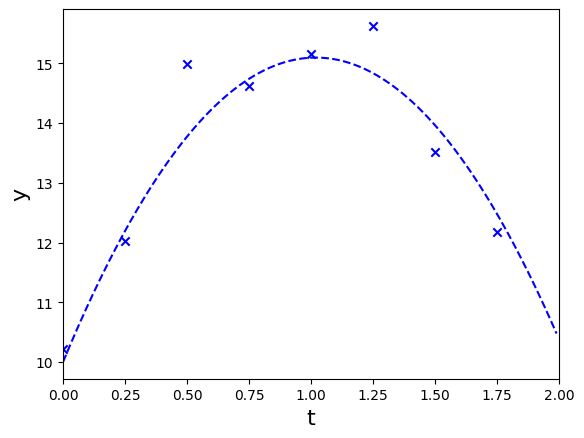

In [16]:
# Plot fine grid solution, observed data
plt.figure()
plt.plot(t_grid.numpy(), y_true, color = 'b', linestyle = '--')

plt.scatter(t_data.numpy(), y_data.numpy(), color = 'b', marker ='x')

plt.xlabel('t', fontsize = 16)
plt.ylabel('y', fontsize = 16)
plt.xlim(0.00, 2.00)
plt.show()

## 3. Using analytical solution

Using the guide in the lecture handout (if you want), write a function that returns a 'design matrix' corresponding to the analytical solution given an input of time points.



In [17]:
def construct_design_matrix(t_rows):
    one_col = torch.ones(t_rows.shape[0], 1)
    time_col = t_rows.view(-1,1)
    quad_col = -0.5 * (t_rows**2).view(-1,1)

    X = torch.cat([one_col, time_col, quad_col], dim = 1)
    return X

Now, use the above to evaluate the analytical solution for both the fine grid and observed data time grid and compare with the corresponding ODE solver outputs.

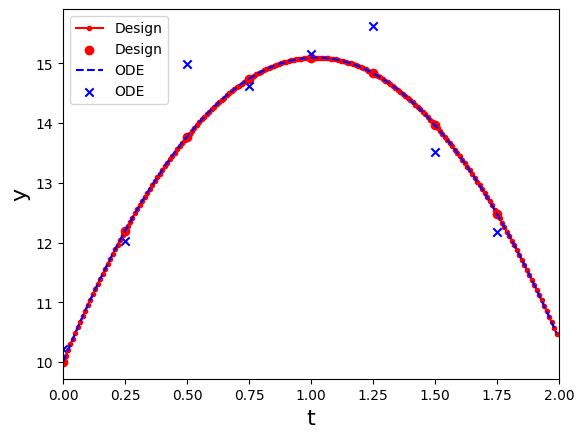

In [18]:
X = construct_design_matrix(t_grid)
y_design = X @ w_true

X_data = construct_design_matrix(t_data)
y_design_data = X_data @ w_true

plt.figure()

#Design
plt.plot(t_grid, y_design, 'ro-', label = 'Design', markersize = '3')
plt.scatter(t_data, y_design_data.numpy(), label = 'Design', color = 'r', marker ='o')

# ODE
plt.plot(t_grid, y_true, label = 'ODE', color = 'b', linestyle = '--')
plt.scatter(t_data, y_data.numpy(), label = 'ODE', color = 'b', marker ='x')

plt.xlabel('t', fontsize = 16)
plt.ylabel('y', fontsize = 16)
plt.legend()
plt.xlim(0.00, 2.00)
plt.legend(loc='upper left')
plt.show()

## 4. Recovering parameters

Following the guidance of the lecture notes, estimate the parameters $h_0$, $v_0$ and $g$ (assuming $g$ is unknown for fun!) using *data* you generated using the 'true' parameters above (that is, while you were 'being Nature'; now you are the engineer/scientist).

Implement each of the following methods and compare their results to each other and to the true values:

- `torch.linalg.lstsq`.
- `torch.linalg.pinv`.
- `torch.optim.SGD` 

In [19]:
# Solution using lstsq
lstsq_result = torch.linalg.lstsq(X_data, y_data)
w_lstsq = lstsq_result.solution

# Solution using pseudoinverse
w_pinv = torch.linalg.pinv(X_data) @ y_data

# Solution using gradient descent
w = torch.zeros(X_data.shape[1], requires_grad=True)

# Loss function, sum square residuals
def loss_fn(w):
  return torch.norm(y_data - X_data @ w) ** 2

# Optimizer
learning_rate = 0.005
optimizer = torch.optim.SGD([w], lr=learning_rate)

# Gradient Descent Loop
num_iterations = 10000
for i in range(num_iterations):
  optimizer.zero_grad()
  loss = loss_fn(w)
  loss.backward()
  optimizer.step()

# Create copy of x that doesn't track gradients anymore
w_gd = w.detach()

# Comparison
print("\nUsing torch.linalg.lstsq:")
print(w_lstsq)
print("\nUsing torch.linalg.pinv:")
print(w_pinv)
print("\nUsing Gradient Descent:")
print(w_gd)
print("\nTrue:")
print(w_true)


Using torch.linalg.lstsq:
tensor([10.1276, 10.8420, 11.1072])

Using torch.linalg.pinv:
tensor([10.1276, 10.8420, 11.1072])

Using Gradient Descent:
tensor([10.1280, 10.8407, 11.1057])

True:
tensor([10.0000, 10.0000,  9.8100])


## 5. Regularisation.
Re-consider the above problem but, following the lectures for guidance, now

- Implement additional 'regularisation' using 'stacking' and *one of* the `lstsq` or `pinv` methods, and such that the result depends on a regularisation parameter $\lambda$ that the user can choose.
- Plot recovered solutions for a large range of $\lambda$. In particular, vary the $\lambda$ values over large ranges e.g. $10^{-5}$ to $10^{5}$. You can use e.g. `torch.logspace` or generate first powers yourself and use lambda = 10^power, and plot what happens as we go from very little regularisation to dominant regularisation.

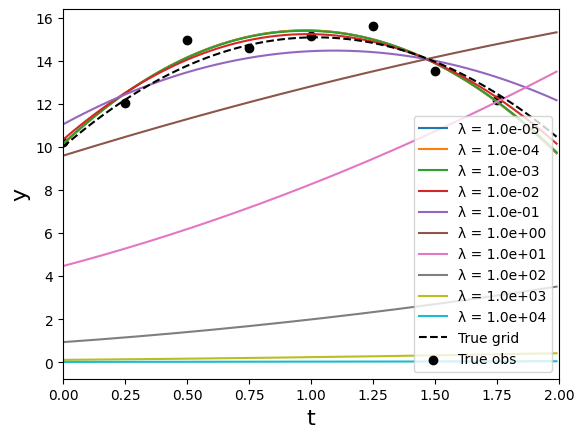

In [20]:
# Regularisation parameter (lambda)
lambda_reg = torch.logspace(-5, 4, 10)

w_reg_solutions = []

for lam in lambda_reg:
    # Augment the design matrix and observation vector
    X_aug = torch.cat([X_data, torch.sqrt(lam) * torch.eye(X_data.shape[1])], dim=0)
    y_aug = torch.cat([y_data, torch.zeros(X_data.shape[1])])

    # Solution using least squares with regularisation
    lstsq_result_reg = torch.linalg.lstsq(X_aug, y_aug)
    w_reg = lstsq_result_reg.solution
    w_reg_solutions.append(w_reg)

w_reg_solutions = torch.stack(w_reg_solutions)

plt.figure()
for i, lam in enumerate(lambda_reg):
    plt.plot(t_grid.numpy(), X @ w_reg_solutions[i], label=f'λ = {lam:.1e}')

plt.plot(t_grid.numpy(), y_true, color = 'k', linestyle = '--', label = 'True grid')
plt.scatter(t_data.numpy(), y_data.numpy(), color = 'k', marker ='o', label = 'True obs')

plt.xlabel('t', fontsize = 16)
plt.ylabel('y', fontsize = 16)
plt.xlim(0.00, 2.00)
plt.legend(loc = 'lower right')
plt.show()